## Template based decoding

* compute the mean response (response template) per category

* decode the nearest template for each response (over n-1 trials by excluding current trial from template)

* confusion matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import confusion
from confusion import generate_confusion_matrix
from data_loader import SessionDataLoader
from spikeplot import raster
from spikes.filters import gaussian_filter, exp_filter
from spikes.binning import bin_spikes
from template_decoding import (
    compute_distance_to_templates,
    compute_templates,
    decode,
    unbias_templates
)

%load_ext autoreload
%autoreload 2

In [2]:
data_loader = SessionDataLoader("GreBlu9508M", 1)

In [3]:
table = data_loader.load_table()

In [4]:
t_arr, spikes = bin_spikes(table["spike_times"], min_time=0.0, max_time=0.6)
spikes_filtered = exp_filter(spikes, 5.0)

table["binned_spikes"] = spikes.tolist()
table["psth"] = spikes_filtered.tolist()

In [5]:
unit_table = table[table["unit"] == (14, 1)]

## Stimulus Decoding

First: Compute templates. Includes how many were included in the average so that the proper amount can be subtracted later on.

In [19]:
templates = compute_templates(unit_table, "stim", "psth")

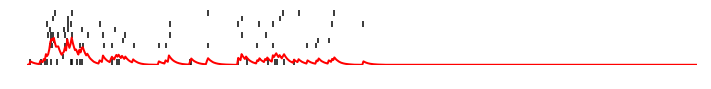

In [20]:
plt.figure(figsize=(12, 1))
raster.plot(unit_table[unit_table["stim"] == "110"]["spike_times"], 0, 0.6)
scale = plt.ylim()[1] / 2.0
plt.plot(
    t_arr,
    scale * templates.get_value("110", "psth") / np.max(templates.get_value("110", "psth")),
    color="red",
    linewidth=2)
plt.axis("off")
plt.show()

Second: Subtract off one trial from each template so that each row gets a column called "selfless_template"---the template for that stim, minus the current trial

In [21]:
if "psth_template" in unit_table: unit_table.drop("psth_template", 1, inplace=True)
unit_table = unbias_templates(unit_table, templates, "stim", "psth")

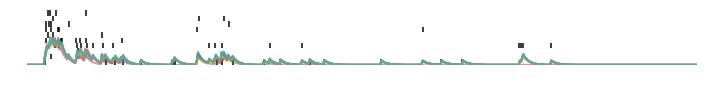

In [22]:
plt.figure(figsize=(12, 1))
raster.plot(unit_table[unit_table["stim"] == "112"]["spike_times"], 0, 0.6)
scale = plt.ylim()[1] / 2.0

for psth in unit_table[unit_table["stim"] == "112"]["selfless_template"]:
    if np.max(psth):
        plt.plot(
            t_arr,
            scale * np.array(psth) / np.max(psth),
            linewidth=2,
            alpha=0.5)
    
plt.axis("off")
plt.show()

Third: Compute distances of each trial to each template

In [10]:
# NEED TO DO THIS FIRST...
unit_table = unit_table.sort_values(["call_type", "stim"])
compute_distance_to_templates.clear_cache()
distances = compute_distance_to_templates(unit_table, "stim", "psth")

Finally, sort the rows by call type, generate confusion matrix, compute mutual information and decoding accuracy.

In [11]:
actual = unit_table["stim"]
predicted = decode(unit_table, distances, "stim")

conf = generate_confusion_matrix(actual, predicted, joint=False)

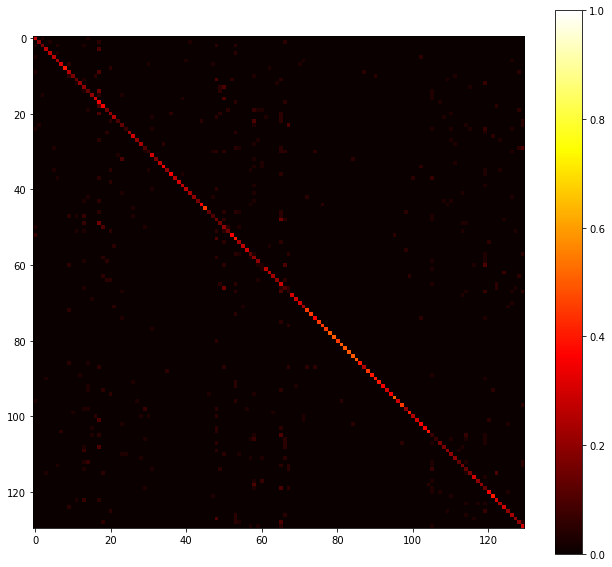

Mutual Information: 5.42 bits
Accuracy: 64.76%


In [26]:
plt.figure(figsize=(11, 10))
plt.imshow(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)

## Call Type Decoding

In [32]:
templates = compute_templates(unit_table, "call_type", "psth")

In [33]:
if "psth_template" in unit_table: unit_table.drop("psth_template", 1, inplace=True)
unit_table = unbias_templates(unit_table, templates, "call_type", "psth")

In [34]:
compute_distance_to_templates.clear_cache()
distances = compute_distance_to_templates(unit_table, "call_type", "psth")

In [39]:
unit_table = unit_table.sort_values(["call_type", "stim"])

actual = unit_table["call_type"]
predicted = decode(unit_table, distances, "call_type")

conf = generate_confusion_matrix(actual, predicted, joint=False)

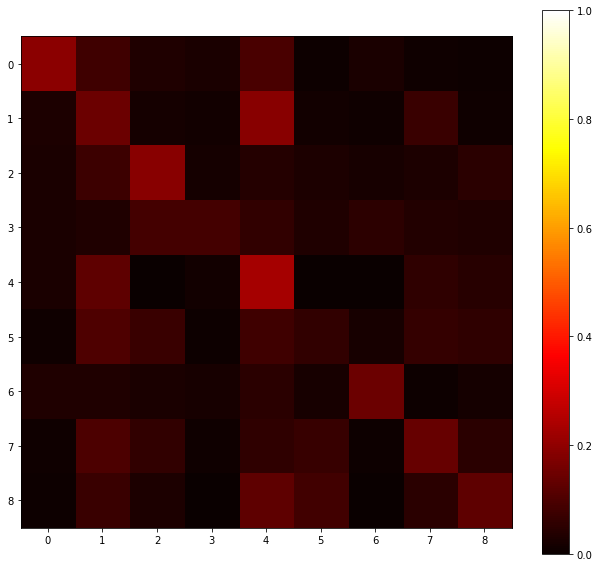

Mutual Information: 0.44 bits
Accuracy: 31.46%


In [40]:
plt.figure(figsize=(11, 10))
plt.imshow(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)